In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from math import ceil, sqrt
import copy

# Heston Model

In [ ]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
        """
        Inputs:
        - S0, v0: initial parameters for asset and variance
        - rho   : correlation between asset returns and variance
        - kappa : rate of mean reversion in variance process
        - theta : long-term mean of variance process
        - sigma : vol of vol / volatility of variance process
        - T     : time of simulation
        - N     : number of time steps
        - M     : number of scenarios / simulations
        
        Outputs:
        - asset prices over time (numpy array)
        - variance over time (numpy array)
        """
        # initialise other parameters
        dt = T/N
        mu = np.array([0,0])
        cov = np.array([[1,rho],
                        [rho,1]])

        # arrays for storing prices and variances
        S = np.full(shape=(N+1,M), fill_value=S0)
        v = np.full(shape=(N+1,M), fill_value=v0)

        # sampling correlated brownian motions under risk-neutral measure
        Z = np.random.multivariate_normal(mu, cov, (N,M))

        for i in range(1,N+1):
            S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
            v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
        
        return S, v

In [ ]:
class MultiDimensionalHeston:
    def __init__(self, initial_prices, interest_rate, dividends, volatilities, correlation_matrix):
        self.initial_prices = initial_prices
        self.interest_rate = interest_rate
        self.dividends = dividends
        self.correlation_matrix = correlation_matrix
        self.dimension = len(initial_prices)
    

    def Simulate_Next_State(self, current_price, current_variance, current_time, diffusion_times, nb_paths):
        """ Simulate conditionnal stock prices under BS model until expiry and with constant timestep """
        delta_time = diffusion_times[0] - current_time
        dW = np.sqrt(delta_time) * np.random.randn(nb_paths, len(diffusion_times), self.dimension)
        cst = self.interest_rate - self.dividends - 0.5 * (np.sqrt(current_variance) ** 2)
        W = np.cumsum(np.matmul(dW, self.var_cov), axis = 1)
        S = current_price[:, np.newaxis, np.newaxis, :] * np.exp(cst * (diffusion_times[np.newaxis, :, np.newaxis] - current_time) + np.sqrt(current_variance) * W)
      
        return S

In [ ]:
# Parameters
# simulation dependent
S0 = 90             # asset price
T = 3.0                # time in years
r = 0.05               # risk-free rate
N = 9                # number of time steps in simulation
M = 8192               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

In [ ]:
rho_p = 0.7

S_1,v_1 = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_2,v_2 = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)

S = np.stack((S_1, S_2), axis=0)

S.T.shape

(8192, 10, 2)

# Payoff Management

In [ ]:
class Payoff:
    def __init__(self, strike, option_type):
        self.strike = strike
        self.option_type = option_type
        
    def value(self, asset_prices, interest_rate, dates, k=0):
        if (self.option_type == 0):
            # max call
            return np.exp(-interest_rate * dates[np.newaxis, k:]) * np.maximum(asset_prices.max(axis = 2) - self.strike, 0)
        
        elif (self.option_type == 1):
            # max put
            return np.exp(-interest_rate * dates[np.newaxis, k:]) * np.maximum(self.strike - asset_prices.min(axis = 2), 0)
        
        elif (self.option_type == 2):
            d = len(asset_prices[0][0])
            # geometric call
            np.exp(-interest_rate * dates[np.newaxis, k:]) * np.maximum(asset_prices.prod(axis = 2)**(1/d) - self.strike, 0)

# Neural Net Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def Build_Neural_Network(nn_structure):
    
    nb_hidden_layers = len(nn_structure) - 2
    assert nb_hidden_layers >= 2, " A neural network has a least two layers : input and output "
    
    layers = []
        
    for i in range(0, nb_hidden_layers):
        layers += [nn.Linear(nn_structure[i], nn_structure[i + 1]), nn.BatchNorm1d(nn_structure[i + 1]), nn.ReLU()]
      
    layers += [torch.nn.Linear(nn_structure[nb_hidden_layers], nn_structure[nb_hidden_layers + 1]), torch.nn.Sigmoid()]
    
    return nn.Sequential(*layers)

In [ ]:
def model_train(nn_structure, nn_hyper_params, model_params, nb_epoch_before_display, re_use_nn_params = False):
    
    # nn_structure : list containing specification of hidden layer : 
    # nn_hyper_params : dict containing nn hyperparameters
    # model_params : dict containing BS model parameters
    # re_use_nn_params : if True : we previously trained nn to initialize current nn weights

    #################################################################################################################
    ####################################################                  MODELS INIT
    
    N = len(model_params['diffusion_times']) - 1
    nb_batches = ceil(nn_hyper_params['inputs_size'] / nn_hyper_params['batch_size'])
    
    nn_base = Build_Neural_Network(nn_structure)
    f = [copy.deepcopy(nn_base).to(device) for i in range(N - 1)]
    optimizers = [torch.optim.Adam(f[i].parameters(), lr = nn_hyper_params['lr']) for i in range(N - 1)]
    BS = MultiDimensionalHeston(model_params['initial_prices'], model_params['interest_rate'], model_params['dividends'], model_params['correlation_matrix'])
    losses = np.array([[0.0] * (N - 1)] * (nn_hyper_params['nb_epochs'] // nb_epoch_before_display))
    
    comp = 0
    
    #################################################################################################################
    ####################################################                  TRAINING

    for epoch in range(nn_hyper_params['nb_epochs']):
        S_1,v_1 = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
        S_2,v_2 = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
        S_train = np.stack((S_1, S_2), axis=0)
        # S_train = BS.Simulate(model_params['diffusion_times'][-1], N, nn_hyper_params['inputs_size'])
        x = torch.from_numpy(S_train).float()
        y = torch.unsqueeze(torch.from_numpy(my_payoff.value(S_train, model_params['interest_rate'], model_params['diffusion_times'])), dim=2).float()
        payoff_tau = [y[i * nn_hyper_params['batch_size'] : min((i + 1) * nn_hyper_params['batch_size'], nn_hyper_params['inputs_size']) , N].to(device) for i in range(nb_batches)]
        this_epoch_loss = np.full(N - 1, 0.0)
        
        # bakward induction
        
        for n in range(N - 1, 0, -1):
            inputs = torch.cat((x[:,n], y[:,n]), 1)
            
            if n < N - 2 and re_use_nn_params:
                f[n].parameters = f[n + 1].parameters
            
            for batch in range(nb_batches):
                batch_range = [i for i in range(batch * nn_hyper_params['batch_size'], min((batch + 1) * nn_hyper_params['batch_size'], nn_hyper_params['inputs_size']))]
                this_batch_inputs = inputs[batch_range, :].to(device)
                optimizers[n - 1].zero_grad()
                F_n = f[n - 1](this_batch_inputs)
                f_n = (F_n >= 0.5).detach().float()
                payoffs_batch = y[batch_range , n].to(device)
                payoff_tau[batch] = payoffs_batch * f_n + payoff_tau[batch] * (1 - f_n)
                z = torch.mean(torch.mul(torch.subtract(payoff_tau[batch], payoffs_batch), F_n))
                this_epoch_loss[n - 1] += z.item() / float(nb_batches)
                z.backward()
                optimizers[n - 1].step()
                
        if(epoch % nb_epoch_before_display == 0):
            losses[comp] = this_epoch_loss 
            print('epoch {}, losses : {}'.format(epoch, losses[comp]))
            print('\n')
            comp += 1
                
    return f, losses

## Test

In [ ]:
##### BS parameters
nb_assets = 2   # d = 2, 3, 5, 10
expiry = 3      
nb_ex_dates = 9
strike = 100
my_payoff = Payoff(strike, 0)

# NN parameters
nb_hidden_layers = 3
nn_units = [nb_assets + 1] + [nb_assets + 40 for i in range(nb_hidden_layers - 1)] + [1]
nb_epoch_before_display = 100

nn_units

[3, 42, 42, 1]

In [ ]:
nn_hp = {'lr' : 0.001, 'nb_epochs' : 3000, 'batch_size' : 8192, 'inputs_size' : 8192*1}

BS_params = {'initial_prices' : np.full(nb_assets, 90),  # S_0 = 90, 100, 110
             'interest_rate' : 0.05,
            'dividends' : np.full(nb_assets, 0.1),
            'volatilities' : np.full(nb_assets, 0.2),
            'diffusion_times' : np.linspace(0, expiry, nb_ex_dates + 1),
            'correlation_matrix' : np.eye(nb_assets)}

my_models, losses = model_train(nn_units, nn_hp, BS_params, nb_epoch_before_display)

IndexError: ignored

Text(0, 0.5, 'loss')

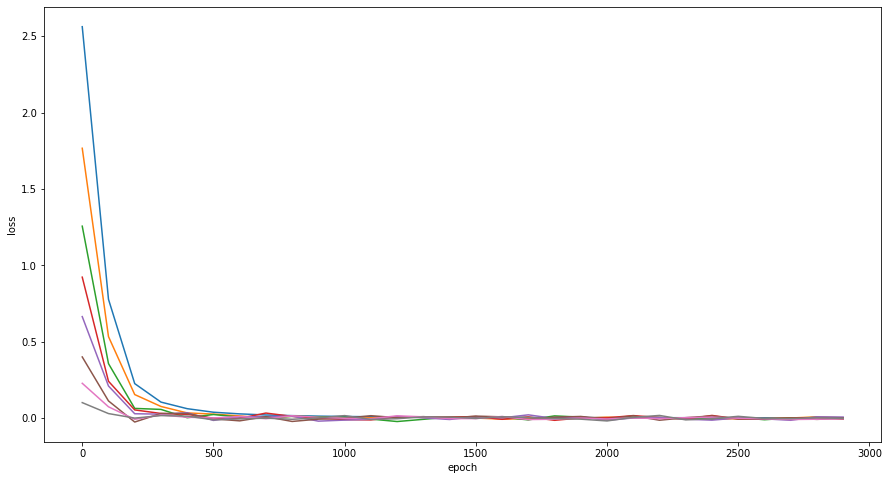

In [ ]:
epoch = np.array([i * nb_epoch_before_display for i in range(nn_hp['nb_epochs'] // nb_epoch_before_display)])
plt.figure(figsize=(15,8))
for i in range(len(losses[0])):
    plt.plot(epoch, losses[:,i])
plt.xlabel("epoch")
plt.ylabel("loss")

# # Lower Bound

In [ ]:
K_L = 1096000
BS_lower = MultiDimensionalBS(BS_params['initial_prices'], BS_params['interest_rate'], BS_params['dividends'], BS_params['volatilities'], BS_params['correlation_matrix'])
S_lower = BS_lower.Simulate(expiry, nb_ex_dates, K_L)
x = torch.from_numpy(S_lower).float()
y = torch.unsqueeze(torch.from_numpy(my_payoff.value(S_lower, BS_params['interest_rate'], BS_params['diffusion_times'])), dim=2).float()

In [ ]:
# init
tau = y[:,nb_ex_dates].new_full(y[:,nb_ex_dates].shape, nb_ex_dates).to(device)
payoff_tau = y[:,nb_ex_dates].to(device)

# backward induction
for n in range(nb_ex_dates - 1, 0, -1):
    inputs = torch.cat((x[:,n], y[:,n]), 1)
    f_n = (my_models[n - 1](inputs.to(device)) >= 0.5).detach().float()
    tau = n * f_n + tau * (1 - f_n)
    payoffs = y[:, n].to(device)
    payoff_tau = payoffs * f_n + payoff_tau * (1 - f_n)
    print(n, 'reward :', payoff_tau.mean())
    
# initial date
payoffs = y[:,0].to(device)
f_n = (payoffs >= (payoff_tau).mean()).detach().float()
tau *= (1 - f_n)
payoff_tau = payoffs * f_n + payoff_tau * (1 - f_n)

lower = payoff_tau
lower_bound = lower.mean().item()
print(0, 'reward :', payoff_tau.mean())

8 reward : tensor(15.2633)
7 reward : tensor(15.7495)
6 reward : tensor(16.0980)
5 reward : tensor(16.3628)
4 reward : tensor(16.5184)
3 reward : tensor(16.5925)
2 reward : tensor(16.6061)
1 reward : tensor(16.6061)
0 reward : tensor(16.6061)


In [ ]:
print('tau :', round(tau.mean().item(), 3), 'lower bound :', round(lower_bound, 3))

tau : 7.668 lower bound : 16.606


# # Upper Bound

In [ ]:
J = 16384
K_U = 1024
BS_upper = MultiDimensionalBS(BS_params['initial_prices'], BS_params['interest_rate'], BS_params['dividends'], BS_params['volatilities'], BS_params['correlation_matrix'])

In [ ]:
S_upper = BS_upper.Simulate(expiry, nb_ex_dates, K_U)
x = torch.from_numpy(S_upper).float()
y = torch.unsqueeze(torch.from_numpy(my_payoff.value(S_upper, BS_params['interest_rate'], BS_params['diffusion_times'])), dim=2).float()

In [ ]:
S_cond = BS_upper.Simulate_Next_State(S_upper[:, nb_ex_dates - 1, :], BS_params['diffusion_times'][nb_ex_dates - 1], BS_params['diffusion_times'][nb_ex_dates:], J)
y_cond = [my_payoff.value(S_cond[k], BS_params['interest_rate'], BS_params['diffusion_times'][nb_ex_dates:]) for k in range(K_U)]
C_n_1 = torch.from_numpy(np.mean(np.squeeze([y_cond[k] for k in range(K_U)], axis = 2), axis = 1)).to(device)
mg_increments = torch.from_numpy(np.array([[0.0] * K_U] * (nb_ex_dates + 1)))
mg_increments[nb_ex_dates] = y[:, nb_ex_dates, 0].to(device) - C_n_1
f_n = [[torch.from_numpy(np.array([[1.0] * 1] * J)).to(device)] * 1] * K_U

for n in range(nb_ex_dates - 1, 0, -1):
    S_cond = BS_upper.Simulate_Next_State(S_upper[:, n - 1, :], BS_params['diffusion_times'][n - 1], BS_params['diffusion_times'][n:], J)
    y_cond = [torch.unsqueeze(torch.from_numpy(my_payoff.value(S_cond[k], BS_params['interest_rate'], BS_params['diffusion_times'][n:])), dim = 2).float() for k in range(K_U)]
    S_cond = torch.from_numpy(S_cond).float()
    
    inputs = [[torch.cat((S_cond[k][:, m], y_cond[k][:, m]), 1) for m in range(0, nb_ex_dates - n)] for k in range(K_U)]
    payoff_tau = [y_cond[k][:, nb_ex_dates - n].to(device) for k in range(K_U)]
        
    if (not (n == nb_ex_dates - 1)):
        f_n = [[(my_models[n + m - 1](inputs[k][m].to(device)) >= 0.5).detach().float() for m in range(0, nb_ex_dates - n)] for k in range(K_U)]
        
        for m in range(nb_ex_dates - n - 1, -1, -1):
            payoff_tau = [y_cond[k][:, m, :].to(device) * f_n[k][m] + (1 - f_n[k][m]) * payoff_tau[k] for k in range(K_U)]
    
    C_n = C_n_1
    C_n_1 = [torch.mean(torch.squeeze(payoff_tau[k], dim = 1)).item() for k in range(K_U)]
    C_n_1 = torch.from_numpy(np.array(C_n_1)).to(device)
        
    inputs = torch.cat((x[:,n], y[:,n]), 1)
    f_n = (my_models[n - 1](inputs.to(device)) >= 0.5).detach().float()
    mg_increments[n] = (y[:, n, 0].to(device) - C_n) * torch.squeeze(f_n, dim = 1) + C_n - C_n_1
    
mg_doob = torch.cumsum(torch.transpose(mg_increments, 0, 1), dim = 1)

upper = (y[:,:,0].to(device) - mg_doob.to(device)).max(dim = 1).values
upper_bound = upper.mean().item()

In [ ]:
print('upper bound :', round(upper_bound, 3))

In [ ]:
IC_inf = round(lower_bound - 1.96 * torch.std(lower).item() / sqrt(K_L), 3)
IC_sup = round(upper_bound + 1.96 * torch.std(upper).item() / sqrt(K_U), 3)

print('- lower bound :', round(lower_bound, 3))
print('- upper bound :', round(upper_bound, 3))
print('- point estimator :', round((lower_bound + upper_bound) / 2.0, 3))
print('')
print('IC 95% :', (IC_inf, IC_sup))